# Hello World: PyTorch CIFAR-10 Image Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vuhung16au/pytorch-mastery/blob/main/examples/hello-pytorch-cifar.ipynb)
[![View on GitHub](https://img.shields.io/badge/View_on-GitHub-blue?logo=github)](https://github.com/vuhung16au/pytorch-mastery/blob/main/examples/hello-pytorch-cifar.ipynb)

This notebook demonstrates the fundamentals of PyTorch through a simple image classification task using the CIFAR-10 dataset. It's designed as a "Hello World" introduction to PyTorch for learners transitioning from TensorFlow.

## Learning Objectives
- Understand PyTorch tensor operations and autograd
- Build a basic CNN model using `nn.Module`
- Implement manual training loops (vs TensorFlow's `model.fit()`)
- Use PyTorch data loaders and transformations
- Monitor training with TensorBoard

## CIFAR-10 Dataset
CIFAR-10 contains 60,000 32x32 color images in 10 classes:
- 🛩️ airplane, 🚗 automobile, 🐦 bird, 🐱 cat, 🦌 deer
- 🐶 dog, 🐸 frog, 🐴 horse, 🚢 ship, 🚛 truck

**Dataset Source**: https://www.cs.toronto.edu/~kriz/cifar.html

---

## 1. Environment Setup and Runtime Detection

Following PyTorch best practices for cross-platform compatibility:

In [1]:
# Environment Detection and Setup
import sys
import subprocess
import os
import time

# Detect the runtime environment
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules or "kaggle" in os.environ.get('KAGGLE_URL_BASE', '')
IS_LOCAL = not (IS_COLAB or IS_KAGGLE)

print(f"🌐 Environment detected:")
print(f"  - Local: {IS_LOCAL}")
print(f"  - Google Colab: {IS_COLAB}")
print(f"  - Kaggle: {IS_KAGGLE}")

# Platform-specific system setup
if IS_COLAB:
    print("\n🔧 Setting up Google Colab environment...")
    # Colab usually has PyTorch pre-installed
elif IS_KAGGLE:
    print("\n🔧 Setting up Kaggle environment...")
    # Kaggle usually has most packages pre-installed
else:
    print("\n🔧 Setting up local environment...")

🌐 Environment detected:
  - Local: False
  - Google Colab: True
  - Kaggle: False

🔧 Setting up Google Colab environment...


In [2]:
# Install required packages based on platform
required_packages = [
    "torch",
    "torchvision",
    "matplotlib",
    "tensorboard"
]

print("📦 Installing required packages...")
for package in required_packages:
    if IS_COLAB or IS_KAGGLE:
        # Use IPython magic commands for notebook environments
        try:
            exec(f"!pip install -q {package}")
            print(f"✅ {package}")
        except:
            print(f"⚠️ {package} (may already be installed)")
    else:
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", package],
                          capture_output=True, check=True)
            print(f"✅ {package}")
        except subprocess.CalledProcessError:
            print(f"⚠️ {package} (may already be installed)")

print("\n🎉 Package installation completed!")

📦 Installing required packages...
⚠️ torch (may already be installed)
⚠️ torchvision (may already be installed)
⚠️ matplotlib (may already be installed)
⚠️ tensorboard (may already be installed)

🎉 Package installation completed!


In [3]:
# Verify PyTorch installation and import core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import tempfile

print(f"🔥 PyTorch {torch.__version__} ready!")
print(f"🖥️ CUDA available: {torch.cuda.is_available()}")
print(f"🎯 Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n💾 Using device: {device}")

🔥 PyTorch 2.8.0+cu126 ready!
🖥️ CUDA available: True
🎯 Device: GPU

💾 Using device: cuda


## 2. TensorBoard Setup for Training Monitoring

PyTorch requires explicit TensorBoard setup (unlike TensorFlow's integrated callbacks):

In [4]:
# Platform-specific TensorBoard log directory setup
def get_run_logdir(name="cifar10_training"):
    """Create unique log directory for this training run."""
    if IS_COLAB:
        root_logdir = "/content/tensorboard_logs"
    elif IS_KAGGLE:
        root_logdir = "./tensorboard_logs"
    else:
        root_logdir = "./tensorboard_logs"

    # Create root directory if it doesn't exist
    os.makedirs(root_logdir, exist_ok=True)

    # Generate unique run directory
    timestamp = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    run_logdir = os.path.join(root_logdir, f"{name}_{timestamp}")
    return run_logdir

# Initialize TensorBoard writer
log_dir = get_run_logdir("hello_pytorch_cifar")
writer = SummaryWriter(log_dir=log_dir)

print(f"📊 TensorBoard logs will be saved to: {log_dir}")
print(f"💡 To view logs, run: tensorboard --logdir={log_dir}")

📊 TensorBoard logs will be saved to: /content/tensorboard_logs/hello_pytorch_cifar_2025_09_21-00_33_18
💡 To view logs, run: tensorboard --logdir=/content/tensorboard_logs/hello_pytorch_cifar_2025_09_21-00_33_18


## 3. Data Loading and Preprocessing

**Key Difference from TensorFlow**: PyTorch uses explicit transforms and DataLoader objects:

In [5]:
# Data transformations for training and testing
# TensorFlow equivalent: tf.keras.preprocessing.image.ImageDataGenerator

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
    transforms.ToTensor(),                   # Convert PIL Image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10 statistics
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Download and load CIFAR-10 dataset
print("📥 Loading CIFAR-10 dataset...")

try:
    # Try to download CIFAR-10 dataset (requires internet)
    print("🌐 Attempting to download CIFAR-10 dataset...")

    # Training dataset
    trainset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )

    # Test dataset
    testset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    print("✅ CIFAR-10 dataset downloaded successfully!")

except Exception as e:
    print(f"⚠️ Cannot download CIFAR-10 dataset: {type(e).__name__}")
    print("🔄 Creating synthetic dataset for demonstration purposes...")

    # Create synthetic CIFAR-10-like dataset for demo when offline
    from torch.utils.data import TensorDataset

    # Generate synthetic data: 32x32 RGB images
    synthetic_train_images = torch.randn(1000, 3, 32, 32)  # 1000 training samples
    synthetic_train_labels = torch.randint(0, 10, (1000,))  # Random labels 0-9

    synthetic_test_images = torch.randn(200, 3, 32, 32)   # 200 test samples
    synthetic_test_labels = torch.randint(0, 10, (200,))   # Random labels 0-9

    # Apply transformations manually to synthetic data
    # Normalize using CIFAR-10 statistics
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)

    synthetic_train_images = (synthetic_train_images - mean) / std
    synthetic_test_images = (synthetic_test_images - mean) / std

    # Create tensor datasets
    trainset = TensorDataset(synthetic_train_images, synthetic_train_labels)
    testset = TensorDataset(synthetic_test_images, synthetic_test_labels)

    print("✅ Synthetic dataset created for demonstration!")
    print("📝 Note: This is random data, not real CIFAR-10 images")

# Data loaders (equivalent to TensorFlow's tf.data.Dataset)
batch_size = 32  # Small batch size for educational purposes

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,      # Shuffle training data
    num_workers=0      # Use 0 for synthetic data to avoid pickling issues
)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,     # Don't shuffle test data
    num_workers=0      # Use 0 for synthetic data to avoid pickling issues
)

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

print(f"✅ Dataset loaded successfully!")
print(f"📊 Training samples: {len(trainset)}")
print(f"📊 Test samples: {len(testset)}")
print(f"🏷️ Classes: {classes}")

📥 Loading CIFAR-10 dataset...
🌐 Attempting to download CIFAR-10 dataset...


100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


✅ CIFAR-10 dataset downloaded successfully!
✅ Dataset loaded successfully!
📊 Training samples: 50000
📊 Test samples: 10000
🏷️ Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 4. Data Visualization

Let's visualize some sample images from our dataset:

/tmp/ipython-input-3813368247.py:28: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


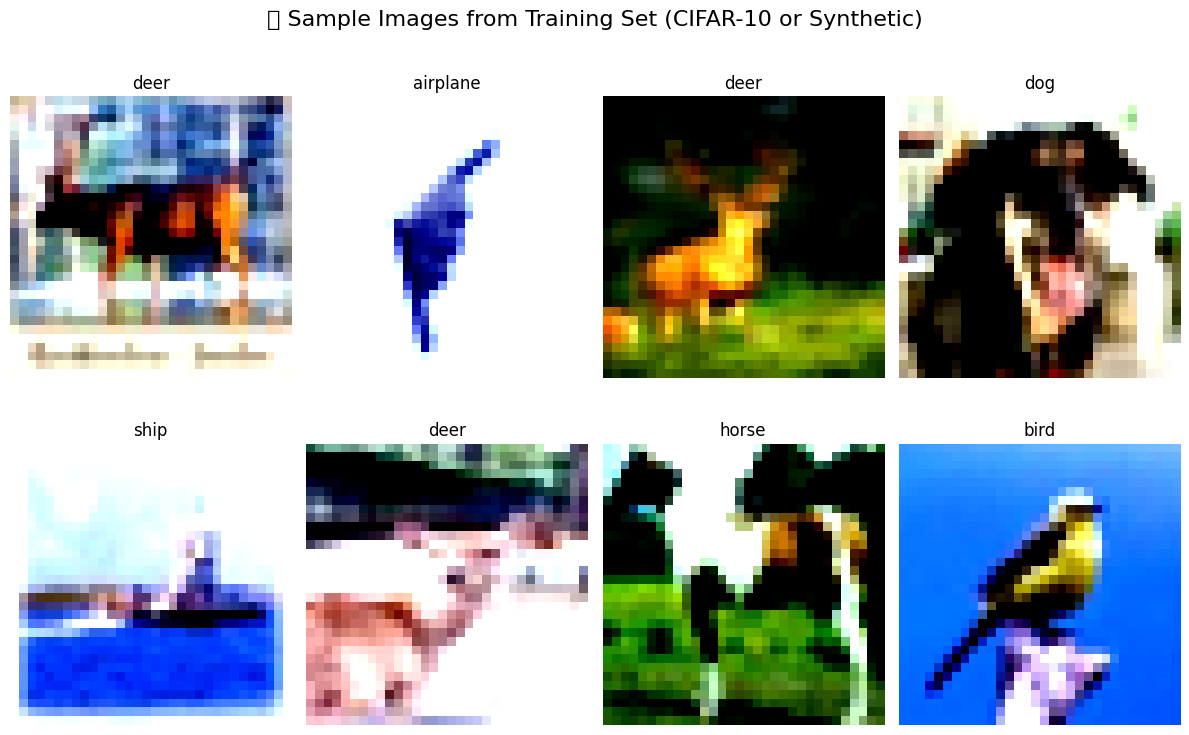

🎯 Batch shape: torch.Size([32, 3, 32, 32]) (batch_size, channels, height, width)
🏷️ Labels shape: torch.Size([32])
📋 Sample labels: ['deer', 'airplane', 'deer', 'dog', 'ship', 'deer', 'horse', 'bird']


In [6]:
# Function to display images
def imshow(img, title=None):
    """Display a tensor image."""
    # Handle both normalized and unnormalized images
    if img.min() < 0:  # If normalized, unnormalize
        img = img / 2 + 0.5

    # Clamp values to [0, 1] range
    img = torch.clamp(img, 0, 1)

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Create a grid of sample images
plt.figure(figsize=(12, 8))
for i in range(8):  # Show first 8 images
    plt.subplot(2, 4, i + 1)
    imshow(images[i], title=f'{classes[labels[i]]}')

plt.suptitle('🖼️ Sample Images from Training Set (CIFAR-10 or Synthetic)', fontsize=16)
plt.tight_layout()
plt.show()

print(f"🎯 Batch shape: {images.shape} (batch_size, channels, height, width)")
print(f"🏷️ Labels shape: {labels.shape}")
print(f"📋 Sample labels: {[classes[label] for label in labels[:8]]}")

## 5. Model Definition - CNN Architecture

**PyTorch vs TensorFlow Model Definition**:
- **PyTorch**: Explicit `nn.Module` subclass with `__init__` and `forward` methods
- **TensorFlow**: `tf.keras.Sequential` or Functional API

Our simple CNN architecture:

In [7]:
class SimpleCIFAR10CNN(nn.Module):
    """
    Simple CNN for CIFAR-10 classification - Hello World PyTorch model.

    Architecture:
    - 2 Convolutional blocks (Conv2d + ReLU + MaxPool)
    - 2 Fully connected layers with dropout
    - Output: 10 classes (CIFAR-10)

    TensorFlow equivalent:
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10)
    ])
    """

    def __init__(self, num_classes=10):
        super(SimpleCIFAR10CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # 3 input channels (RGB)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 -> 64 channels

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce spatial dimensions by half

        # Calculate size after convolutions: 32x32 -> 16x16 -> 8x8
        # Final feature map: 64 channels * 8 * 8 = 4096
        self.fc1 = nn.Linear(64 * 8 * 8, 64)  # First fully connected layer
        self.fc2 = nn.Linear(64, num_classes)  # Output layer

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input batch of images [batch_size, 3, 32, 32]

        Returns:
            torch.Tensor: Class logits [batch_size, num_classes]
        """
        # Convolutional block 1: Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 16, 16]

        # Convolutional block 2: Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 8, 8]

        # Flatten for fully connected layers
        x = x.view(-1, 64 * 8 * 8)            # [batch, 4096]

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))               # [batch, 64]
        x = self.dropout(x)                   # Apply dropout during training
        x = self.fc2(x)                       # [batch, 10] - final logits

        return x

    def get_model_info(self):
        """Return model architecture information."""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        return {
            'model_name': 'SimpleCIFAR10CNN',
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'architecture': 'Conv2d(32) -> Conv2d(64) -> FC(64) -> FC(10)'
        }

# Create model instance and move to device
model = SimpleCIFAR10CNN(num_classes=10).to(device)

# Display model information
model_info = model.get_model_info()
print(f"🧠 Model: {model_info['model_name']}")
print(f"🔢 Total parameters: {model_info['total_parameters']:,}")
print(f"🎯 Trainable parameters: {model_info['trainable_parameters']:,}")
print(f"🏗️ Architecture: {model_info['architecture']}")
print(f"\n📋 Model summary:")
print(model)

🧠 Model: SimpleCIFAR10CNN
🔢 Total parameters: 282,250
🎯 Trainable parameters: 282,250
🏗️ Architecture: Conv2d(32) -> Conv2d(64) -> FC(64) -> FC(10)

📋 Model summary:
SimpleCIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## 6. Loss Function and Optimizer Setup

**Key PyTorch Pattern**: Explicit loss and optimizer definition (vs TensorFlow's `model.compile()`):

In [8]:
# Loss function and optimizer setup
# TensorFlow equivalent: model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print(f"🎯 Loss function: {criterion}")
print(f"🔧 Optimizer: {optimizer}")
print(f"📉 Learning rate scheduler: Step LR (decay by 0.5 every 5 epochs)")
print(f"📊 Initial learning rate: {optimizer.param_groups[0]['lr']}")

🎯 Loss function: CrossEntropyLoss()
🔧 Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
)
📉 Learning rate scheduler: Step LR (decay by 0.5 every 5 epochs)
📊 Initial learning rate: 0.001


## 7. Training Loop Implementation

**Major Difference from TensorFlow**: PyTorch requires manual training loops instead of `model.fit()`.

This gives more control but requires more code:

In [11]:
def train_model(model, trainloader, testloader, criterion, optimizer, scheduler,
                num_epochs=5, device=device):
    """
    Training function with TensorBoard logging.

    TensorFlow equivalent:
    model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test))

    Args:
        model: PyTorch model to train
        trainloader: Training data loader
        testloader: Test data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        num_epochs: Number of training epochs
        device: Device to train on (CPU/GPU)
    """

    print(f"🚀 Starting training for {num_epochs} epochs...")
    print(f"💾 Device: {device}")
    print(f"🔢 Batch size: {batch_size}")
    print(f"📊 Training batches per epoch: {len(trainloader)}")
    print(f"📊 Test batches: {len(testloader)}")
    print("-" * 50)

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()  # Set model to training mode (enables dropout, batch norm)
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (inputs, labels) in enumerate(trainloader):
            # Move data to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients (PyTorch accumulates gradients by default)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()    # Compute gradients
            optimizer.step()   # Update weights

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Log batch-level metrics to TensorBoard
            if batch_idx % 200 == 0:  # Log every 200 batches
                writer.add_scalar('Loss/Train_Batch', loss.item(),
                                epoch * len(trainloader) + batch_idx)

        # Calculate epoch training metrics
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()  # Set model to evaluation mode (disables dropout)
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():  # Disable gradient computation for efficiency
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        # Calculate test metrics
        test_loss = test_loss / len(testloader)
        test_acc = 100 * correct_test / total_test

        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Log epoch-level metrics to TensorBoard
        writer.add_scalar('Loss/Train_Epoch', epoch_loss, epoch)
        writer.add_scalar('Loss/Test', test_loss, epoch)
        writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
        writer.add_scalar('Accuracy/Test', test_acc, epoch)
        writer.add_scalar('Learning_Rate', current_lr, epoch)

        # Log model parameters histogram
        for name, param in model.named_parameters():
            writer.add_histogram(f'Parameters/{name}', param, epoch)

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print(f'  Learning Rate: {current_lr:.6f}')

        # Early stopping for demo (if we reach good accuracy)
        if test_acc > 85.0:  # CIFAR-10 is challenging, 65% is decent for a simple model
            print(f"\n🎉 Early stopping! Achieved {test_acc:.2f}% test accuracy.")
            break

    print("\n✅ Training completed!")
    return model

# Train the model (using small number of epochs for demo)
num_epochs = 8  # Small number for educational purposes
trained_model = train_model(
    model, trainloader, testloader, criterion, optimizer, scheduler,
    num_epochs=num_epochs, device=device
)

🚀 Starting training for 8 epochs...
💾 Device: cuda
🔢 Batch size: 32
📊 Training batches per epoch: 1563
📊 Test batches: 313
--------------------------------------------------
Epoch [1/8]:
  Train Loss: 0.8628, Train Acc: 69.15%
  Test Loss: 0.7602, Test Acc: 73.93%
  Learning Rate: 0.000250
Epoch [2/8]:
  Train Loss: 0.8508, Train Acc: 69.45%
  Test Loss: 0.7564, Test Acc: 73.86%
  Learning Rate: 0.000250
Epoch [3/8]:
  Train Loss: 0.8468, Train Acc: 69.58%
  Test Loss: 0.7568, Test Acc: 74.05%
  Learning Rate: 0.000250
Epoch [4/8]:
  Train Loss: 0.8361, Train Acc: 69.91%
  Test Loss: 0.7474, Test Acc: 74.33%
  Learning Rate: 0.000125
Epoch [5/8]:
  Train Loss: 0.8114, Train Acc: 70.77%
  Test Loss: 0.7400, Test Acc: 74.13%
  Learning Rate: 0.000125
Epoch [6/8]:
  Train Loss: 0.8065, Train Acc: 70.90%
  Test Loss: 0.7433, Test Acc: 74.67%
  Learning Rate: 0.000125
Epoch [7/8]:
  Train Loss: 0.8023, Train Acc: 71.10%
  Test Loss: 0.7415, Test Acc: 74.63%
  Learning Rate: 0.000125
Epoch [

## 8. Model Evaluation and Testing

Let's evaluate our trained model on the test set:

In [12]:
# Evaluate model on test set
def evaluate_model(model, testloader, classes, device=device):
    """
    Evaluate the trained model and show per-class accuracy.
    """
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Overall accuracy
    overall_accuracy = 100 * correct / total
    print(f"🎯 Overall Test Accuracy: {overall_accuracy:.2f}%")
    print("\n📊 Per-class accuracy:")

    # Per-class accuracy
    for i in range(len(classes)):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f"  {classes[i]:>12}: {accuracy:.1f}%")

    return overall_accuracy

# Evaluate the model
print("🔍 Evaluating trained model...")
final_accuracy = evaluate_model(trained_model, testloader, classes)

🔍 Evaluating trained model...
🎯 Overall Test Accuracy: 74.65%

📊 Per-class accuracy:
      airplane: 79.3%
    automobile: 86.9%
          bird: 59.1%
           cat: 52.1%
          deer: 69.5%
           dog: 67.4%
          frog: 81.6%
         horse: 79.6%
          ship: 85.7%
         truck: 85.3%


## 9. Predictions on Sample Images

Let's see how our model performs on some test images:

/tmp/ipython-input-3490239234.py:40: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


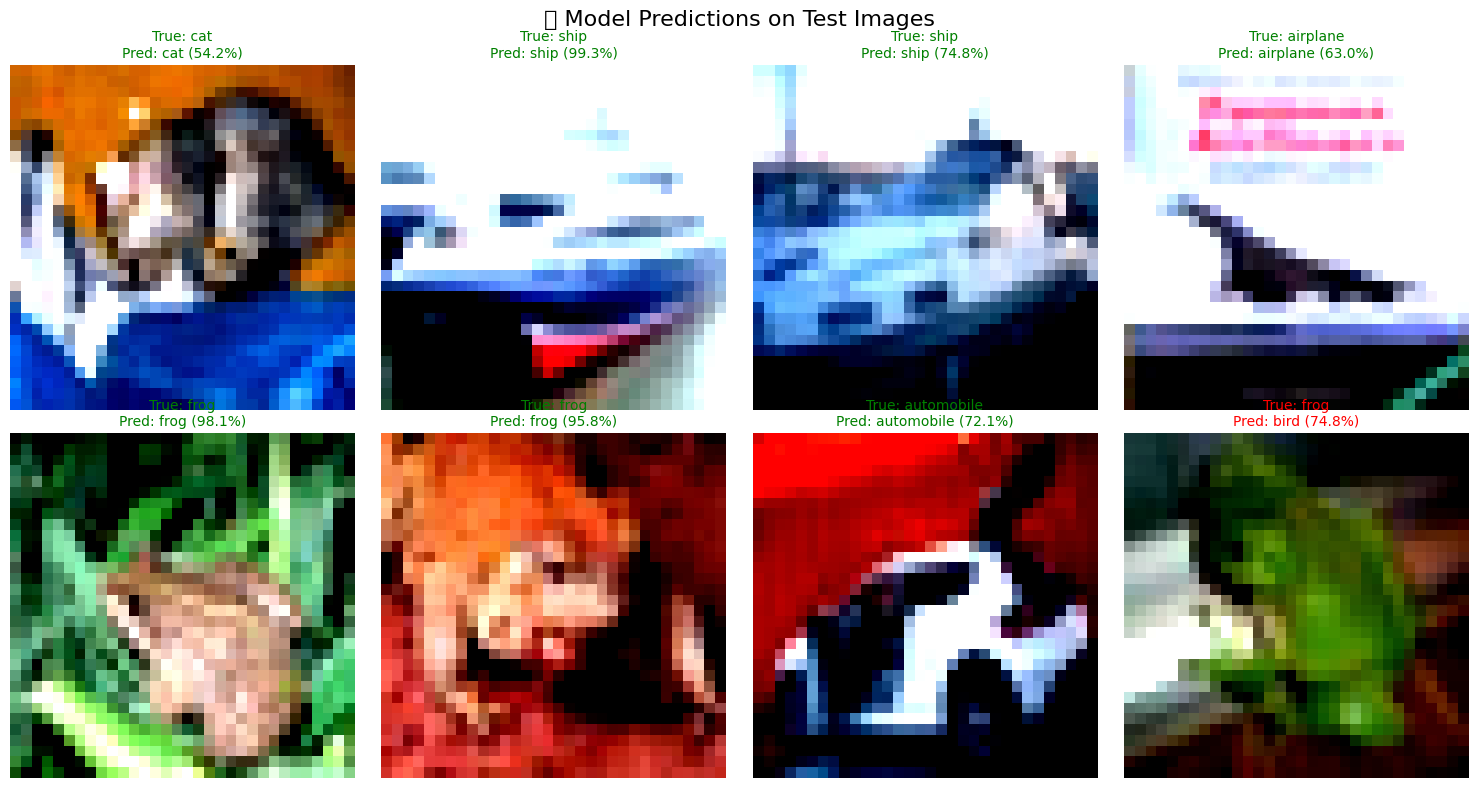

📊 Batch accuracy: 81.2% (26/32 correct)


In [13]:
# Make predictions on sample test images
def predict_samples(model, testloader, classes, num_samples=8, device=device):
    """
    Show predictions on sample test images.
    """
    model.eval()

    # Get a batch of test images
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # Plot results
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        plt.subplot(2, 4, i + 1)

        # Move image back to CPU for plotting
        img = images[i].cpu()
        imshow(img)

        # Get prediction info
        true_label = classes[labels[i]]
        pred_label = classes[predicted[i]]
        confidence = probabilities[i][predicted[i]].item() * 100

        # Color: green if correct, red if wrong
        color = 'green' if predicted[i] == labels[i] else 'red'

        plt.title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                 color=color, fontsize=10)

    plt.suptitle('🔮 Model Predictions on Test Images', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Calculate accuracy for this batch
    correct = (predicted == labels).sum().item()
    batch_accuracy = 100 * correct / len(labels)
    print(f"📊 Batch accuracy: {batch_accuracy:.1f}% ({correct}/{len(labels)} correct)")

# Show sample predictions
predict_samples(trained_model, testloader, classes)

## 10. TensorBoard Visualization Instructions

View your training progress with TensorBoard:

In [14]:
# Close TensorBoard writer
writer.close()

# Display TensorBoard viewing instructions
print("=" * 60)
print("📊 TENSORBOARD VISUALIZATION")
print("=" * 60)
print(f"Log directory: {log_dir}")
print("\n🚀 To view TensorBoard:")

if IS_COLAB:
    print("   In Google Colab:")
    print("   1. Run: %load_ext tensorboard")
    print(f"   2. Run: %tensorboard --logdir {log_dir}")
    print("   3. TensorBoard will appear inline in the notebook")
elif IS_KAGGLE:
    print("   In Kaggle:")
    print(f"   1. Download logs from: {log_dir}")
    print("   2. Run locally: tensorboard --logdir ./tensorboard_logs")
    print("   3. Open http://localhost:6006 in browser")
else:
    print("   Locally:")
    print(f"   1. Run: tensorboard --logdir {log_dir}")
    print("   2. Open http://localhost:6006 in browser")

print("\n📈 Available visualizations:")
print("   • Scalars: Loss, accuracy, learning rate over time")
print("   • Histograms: Model parameter distributions")
print("   • Graphs: Model architecture visualization")
print("=" * 60)

📊 TENSORBOARD VISUALIZATION
Log directory: /content/tensorboard_logs/hello_pytorch_cifar_2025_09_21-00_33_18

🚀 To view TensorBoard:
   In Google Colab:
   1. Run: %load_ext tensorboard
   2. Run: %tensorboard --logdir /content/tensorboard_logs/hello_pytorch_cifar_2025_09_21-00_33_18
   3. TensorBoard will appear inline in the notebook

📈 Available visualizations:
   • Scalars: Loss, accuracy, learning rate over time
   • Histograms: Model parameter distributions
   • Graphs: Model architecture visualization


## 11. Key Learning Points: TensorFlow vs PyTorch

Summary of key differences encountered in this "Hello World" example:

In [15]:
print("""
🎓 KEY LEARNING POINTS: TensorFlow → PyTorch Transition

1. 🏗️ MODEL DEFINITION:
   TensorFlow: tf.keras.Sequential() or Functional API
   PyTorch:    nn.Module subclass with __init__ and forward methods

2. 🔄 TRAINING LOOPS:
   TensorFlow: model.fit() handles everything automatically
   PyTorch:    Manual loops with optimizer.zero_grad(), loss.backward(), optimizer.step()

3. 📊 DATA LOADING:
   TensorFlow: tf.data.Dataset with built-in batching
   PyTorch:    DataLoader with explicit dataset and transforms

4. 🎯 LOSS & OPTIMIZATION:
   TensorFlow: model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
   PyTorch:    Explicit criterion = nn.CrossEntropyLoss() and optimizer = optim.Adam()

5. 💾 DEVICE MANAGEMENT:
   TensorFlow: Mostly automatic with tf.distribute.Strategy
   PyTorch:    Explicit .to(device) calls for model and data

6. 🎭 TRAINING/INFERENCE MODES:
   TensorFlow: Implicit (training=True/False parameter)
   PyTorch:    Explicit model.train() and model.eval() calls

7. 📈 MONITORING:
   TensorFlow: Built-in callbacks and metrics
   PyTorch:    Manual TensorBoard logging with SummaryWriter

🚀 ADVANTAGES OF PYTORCH:
   ✅ More explicit control over training process
   ✅ Dynamic computation graphs (easier debugging)
   ✅ Pythonic and intuitive API
   ✅ Better integration with Hugging Face transformers
   ✅ Immediate execution (no session.run())

🎯 NEXT STEPS:
   1. Practice with more complex architectures
   2. Explore Hugging Face transformers
   3. Learn custom dataset creation
   4. Study advanced PyTorch features (autograd, hooks, etc.)
""")


🎓 KEY LEARNING POINTS: TensorFlow → PyTorch Transition

1. 🏗️ MODEL DEFINITION:
   TensorFlow: tf.keras.Sequential() or Functional API
   PyTorch:    nn.Module subclass with __init__ and forward methods

2. 🔄 TRAINING LOOPS:
   TensorFlow: model.fit() handles everything automatically
   PyTorch:    Manual loops with optimizer.zero_grad(), loss.backward(), optimizer.step()

3. 📊 DATA LOADING:
   TensorFlow: tf.data.Dataset with built-in batching
   PyTorch:    DataLoader with explicit dataset and transforms

4. 🎯 LOSS & OPTIMIZATION:
   TensorFlow: model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
   PyTorch:    Explicit criterion = nn.CrossEntropyLoss() and optimizer = optim.Adam()

5. 💾 DEVICE MANAGEMENT:
   TensorFlow: Mostly automatic with tf.distribute.Strategy
   PyTorch:    Explicit .to(device) calls for model and data

6. 🎭 TRAINING/INFERENCE MODES:
   TensorFlow: Implicit (training=True/False parameter)
   PyTorch:    Explicit model.train() and model.eval

## 12. Model Saving (Optional)

Save your trained model for future use:

In [16]:
# Save the trained model
model_save_path = './hello_pytorch_cifar10_model.pth'

# PyTorch way: Save state dictionary
torch.save(trained_model.state_dict(), model_save_path)
print(f"💾 Model saved to: {model_save_path}")

# To load the model later:
# model = SimpleCIFAR10CNN()
# model.load_state_dict(torch.load(model_save_path))
# model.eval()

print(f"\n🎉 Hello PyTorch CIFAR-10 tutorial completed!")
print(f"📊 Final test accuracy: {final_accuracy:.2f}%")
print(f"🧠 Model parameters: {model.get_model_info()['total_parameters']:,}")
print(f"⏱️ Training epochs: {num_epochs}")

💾 Model saved to: ./hello_pytorch_cifar10_model.pth

🎉 Hello PyTorch CIFAR-10 tutorial completed!
📊 Final test accuracy: 74.65%
🧠 Model parameters: 282,250
⏱️ Training epochs: 8


---

## 🎓 Congratulations!

You've successfully completed your first PyTorch "Hello World" with CIFAR-10! You've learned:

✅ **PyTorch Fundamentals**: Tensors, autograd, and nn.Module  
✅ **Model Definition**: Creating CNN architectures with PyTorch  
✅ **Data Handling**: DataLoaders and transforms  
✅ **Training Loops**: Manual training vs TensorFlow's model.fit()  
✅ **Monitoring**: TensorBoard integration for PyTorch  
✅ **Model Evaluation**: Testing and visualization  

### 🚀 Next Steps in Your PyTorch Journey:

1. **Advanced CNN Architectures**: ResNet, VGG, EfficientNet
2. **Transfer Learning**: Using pre-trained models
3. **Hugging Face Integration**: Modern NLP with transformers
4. **Custom Datasets**: Working with your own data
5. **Advanced Training**: Mixed precision, distributed training

**Happy learning with PyTorch!** 🔥

---

*This notebook demonstrates fundamental PyTorch concepts through a practical CIFAR-10 classification example. For more advanced tutorials and examples, explore the other notebooks in this repository.*